# Importing Packages

In [1]:
# filter warnings
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

# keras imports
import tensorflow as tf


from tensorflow.keras import preprocessing, callbacks 
from tensorflow.keras.models import Model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Flatten

# import seaborn as sns
# import tsfel
import timeit
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os, sys, logging
from PIL import Image
from pathlib import Path as Pathlb


# Custom imports
from scipy import signal
import seaborn as sns


sns.set()

sys.path.insert(0, os.path.abspath(os.path.join('..')))
from MLPackage import config as cfg


os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Setting Logger

In [2]:
project_dir = os.getcwd()[:-5]
log_path = os.path.join(project_dir, 'logs')
temp_dir = os.path.join(project_dir, "temp")

Pathlb(log_path).mkdir(parents=True, exist_ok=True)



def create_logger(level):
    loggerName = "2DCNN_ipynb"
    Pathlb(log_path).mkdir(parents=True, exist_ok=True)
    grey = '\x1b[38;21m'
    blue = '\x1b[38;5;39m'
    yellow = '\x1b[38;5;226m'
    red = '\x1b[38;5;196m'
    bold_red = '\x1b[31;1m'
    reset = '\x1b[0m'

    logger = logging.getLogger(loggerName)
    logger.setLevel(level)
    formatter_colored = logging.Formatter(blue + '[%(asctime)s]-' + yellow + '[%(name)s @%(lineno)d]' + reset + blue + '-[%(levelname)s]' + reset + bold_red + '\t\t%(message)s' + reset, datefmt='%m/%d/%Y %I:%M:%S %p ')
    formatter = logging.Formatter('[%(asctime)s]-[%(name)s @%(lineno)d]-[%(levelname)s]\t\t%(message)s', datefmt='%m/%d/%Y %I:%M:%S %p ')
    file_handler = logging.FileHandler( os.path.join(log_path, loggerName + '_loger.log'), mode = 'w')
    file_handler.setLevel(level)
    file_handler.setFormatter(formatter)
    stream_handler = logging.StreamHandler()
    stream_handler.setLevel(logging.INFO)

    stream_handler.setFormatter(formatter_colored)

    logger.addHandler(file_handler)
    logger.addHandler(stream_handler)
    return logger
logger = create_logger(logging.DEBUG)


logger.info("Importing libraries....")

[11/25/2021 12:32:50 PM ]-[2DCNN_ipynb @37]-[INFO]		Importing libraries....


# Making Base Model

In [3]:
try:
    logger.info(f"Loading { cfg.CNN['base_model'] } model...")
    base_model = eval("tf.keras.applications." + cfg.CNN["base_model"] + "(weights=cfg.CNN['weights'], include_top=cfg.CNN['include_top'])")
    logger.info("Successfully loaded base model and model...")

except Exception as e: 
    
    base_model = None
    logger.error("The base model could NOT be loaded correctly!!!")
    print(e)


base_model.trainable = False

CNN_name = cfg.CNN["base_model"].split(".")[0]

input = tf.keras.layers.Input(shape=cfg.CNN["image_size"], dtype = tf.float64, name="original_img")
x = tf.cast(input, tf.float32)
x = eval("tf.keras.applications." + CNN_name + ".preprocess_input(x)")
x = base_model(x)
output = tf.keras.layers.GlobalMaxPooling2D()(x)




[11/25/2021 12:32:50 PM ]-[2DCNN_ipynb @2]-[INFO]		Loading inception_v3.InceptionV3 model...
[11/25/2021 12:32:55 PM ]-[2DCNN_ipynb @4]-[INFO]		Successfully loaded base model and model...


# The CNN Model

In [4]:
model = tf.keras.Model(input, output, name=CNN_name)
model.summary() 
tf.keras.utils.plot_model(model, to_file=CNN_name + ".png", show_shapes=True)
plt.show()


Model: "inception_v3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 original_img (InputLayer)   [(None, 120, 200, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 120, 200, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 120, 200, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 120, 200, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)            

# Image Preprocessing and Loading

## Loading Images

In [5]:
Loading_path = os.path.join(project_dir, 'Datasets', 'prefeatures.npy')
prefeatures = np.load(Loading_path)
logger.info("prefeature shape: {}".format(prefeatures.shape))


# #CD, PTI, Tmax, Tmin, P50, P60, P70, P80, P90, P100
logger.info("batch_size: {}".format(cfg.CNN["batch_size"]))

[11/25/2021 12:32:59 PM ]-[2DCNN_ipynb @3]-[INFO]		prefeature shape: (2851, 60, 40, 10)
[11/25/2021 12:32:59 PM ]-[2DCNN_ipynb @7]-[INFO]		batch_size: 32


## flatenning Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


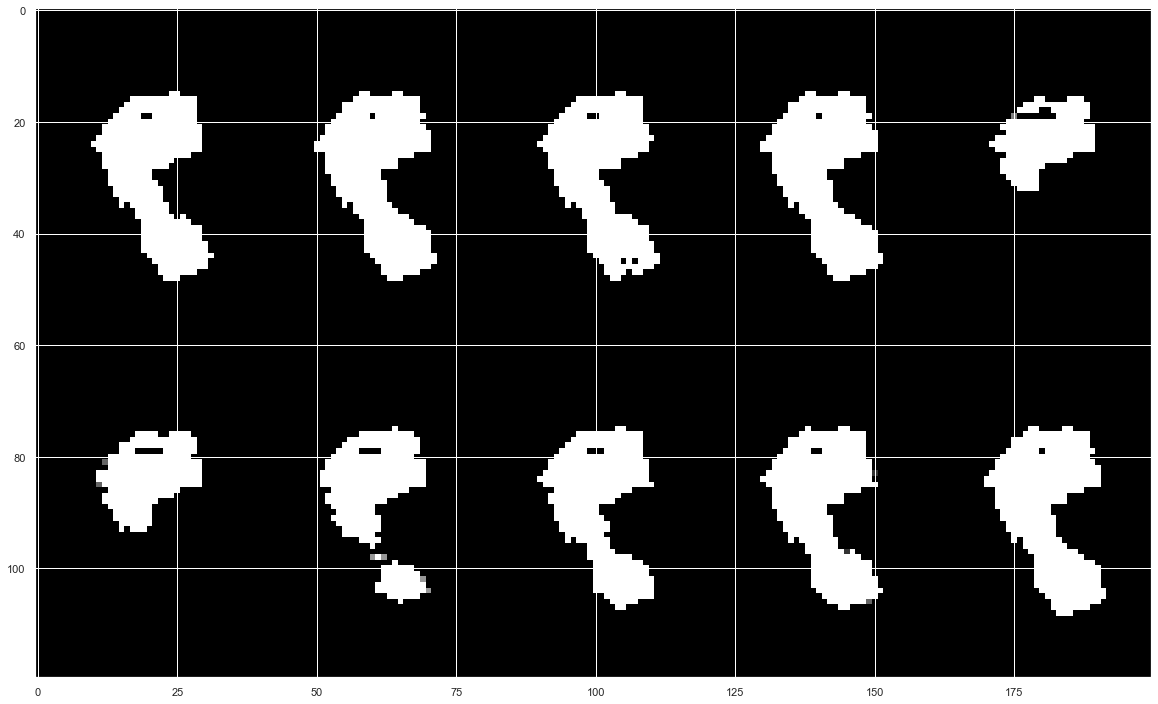

<class 'numpy.ndarray'>
float64


ValueError: Input 0 of layer "inception_v3" is incompatible with the layer: expected shape=(None, 120, 200, 3), found shape=(120, 200, 3)

In [9]:
images  = list()
for sample in prefeatures:
    sample = sample.transpose((2, 0, 1))

    total_image = sample[0,:,:]
    total_image1 = sample[5,:,:]

    for i in range(1,5):
        total_image = np.concatenate((total_image, sample[i,:,:]), axis=1)
        total_image1 = np.concatenate((total_image1, sample[i+5,:,:]), axis=1)




    total_image = np.concatenate((total_image, total_image1), axis=0)
    total_image = total_image[:,:, np.newaxis]
    total_image = np.concatenate((total_image, total_image, total_image), axis=2)

    # print(total_image.shape)
    images.append(total_image)

    plt.figure(figsize=(20,20))
    plt.imshow( total_image)
    plt.show()

    print(type(total_image))
    print(total_image.dtype)



    result = model(total_image)
    print(result)

    break
images =np.array(images)

# Extracting features

In [7]:

Deep_features = np.zeros((1, model.layers[-1].output_shape[1]))
for image in range(0, images.shape[0], cfg.CNN["batch_size"]):
    pic = images[image:image+cfg.CNN["batch_size"],:,:,:]

    feature = model(pic)

    Deep_features = np.append(Deep_features, feature, axis=0)
    if image % 128 == 0:
        logger.info(" ->>> completed images: " + str(image))

    # if image > 128:
    #     break

Deep_features = Deep_features[1:, :]
logger.info(Deep_features.shape)

[11/25/2021 12:33:04 PM ]-[2DCNN_ipynb @9]-[INFO]		 ->>> completed images: 0
[11/25/2021 12:33:09 PM ]-[2DCNN_ipynb @9]-[INFO]		 ->>> completed images: 128
[11/25/2021 12:33:15 PM ]-[2DCNN_ipynb @9]-[INFO]		 ->>> completed images: 256
[11/25/2021 12:33:21 PM ]-[2DCNN_ipynb @9]-[INFO]		 ->>> completed images: 384
[11/25/2021 12:33:27 PM ]-[2DCNN_ipynb @9]-[INFO]		 ->>> completed images: 512
[11/25/2021 12:33:32 PM ]-[2DCNN_ipynb @9]-[INFO]		 ->>> completed images: 640
[11/25/2021 12:33:37 PM ]-[2DCNN_ipynb @9]-[INFO]		 ->>> completed images: 768
[11/25/2021 12:33:43 PM ]-[2DCNN_ipynb @9]-[INFO]		 ->>> completed images: 896
[11/25/2021 12:33:47 PM ]-[2DCNN_ipynb @9]-[INFO]		 ->>> completed images: 1024
[11/25/2021 12:33:51 PM ]-[2DCNN_ipynb @9]-[INFO]		 ->>> completed images: 1152
[11/25/2021 12:33:55 PM ]-[2DCNN_ipynb @9]-[INFO]		 ->>> completed images: 1280
[11/25/2021 12:33:59 PM ]-[2DCNN_ipynb @9]-[INFO]		 ->>> completed images: 1408
[11/25/2021 12:34:04 PM ]-[2DCNN_ipynb @9]-[INFO]	

# Saving Featurs

In [8]:
meta_path = os.path.join(project_dir, 'Datasets', 'metadatalist.npy')
metadata = np.load(meta_path)

logger.info("Metadata shape: {}".format(metadata.shape))
time = int(timeit.default_timer() * 1_000_000)


saving_path = os.path.join(temp_dir, CNN_name+'_features.xlsx')
columnsName = [CNN_name+"_"+str(i) for i in range(Deep_features.shape[1])]  + cfg.label
Deep_features = np.concatenate((Deep_features, metadata[:Deep_features.shape[0], 0:2]), axis=1)

try:
    pd.DataFrame(Deep_features, columns=columnsName).to_excel(saving_path)
except:
    pd.DataFrame(Deep_features, columns=columnsName).to_excel(os.path.join(temp_dir, CNN_name+'_features_'+str(time)+'.xlsx'))


[11/25/2021 12:34:44 PM ]-[2DCNN_ipynb @4]-[INFO]		Metadata shape: (2851, 7)
